In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from itertools import product

import os
import re  # for regex

In [9]:
test_scenario = "modeC_[nieu.km44.2+nieu.km41.2]_(0+40)_iter0"
suffix = '_trial'
raw_path = f"hh_A_{test_scenario}{suffix}.pkl.xz"
trans_path = f"hh_T_{test_scenario}{suffix}.pkl.xz"
exp_path = f"hh_expo_{test_scenario}{suffix}.pkl.xz"
save_dir = "data_model_outputs"
ref_dir = "experiment_scenarios_ref.pkl.xz"


prefix = 'hh_A_modeC'
filters = [f'hh_A_', '.pkl.xz']
f_names = [f for f in os.listdir(save_dir) if prefix in f]
p_names = [f"{save_dir}/{f}" for f in f_names]
s_names = [re.search(fr'{filters[0]}(.*?){filters[1]}', f).group(1) for f in f_names]


# test_path = "hh_A_modeC_[nieu.km44.2+nieu.km41.2]_(0+40)_iter0_trial.pkl.xz"
ref_df = pd.read_pickle(f'{save_dir}/{ref_dir}')
scenarios_info = ref_df.loc[f"{test_scenario}", :]
raw_df = pd.read_pickle(f"{save_dir}/{raw_path}")  #.loc[(slice(1,2),slice(None)),:]
trans_df = pd.read_pickle(f"{save_dir}/{trans_path}")
exp_df = pd.read_pickle(f"{save_dir}/{exp_path}")
# raw2 = raw.copy(deep=True)
# raw.index.set_levels(index={0:'step'}, inplace=True)

In [10]:
# make bool label for flooded homes
# get all homes that are affected by flooding
homes_flooded = raw_df.loc[(1, slice(None)), 'fld_exp'].droplevel('step', axis=0)
homes_flooded = homes_flooded[homes_flooded].index



In [11]:
# how to plot discriminatorily...?
# set plus set?
# make column
test_trans_df = trans_df.copy(deep=True)
test_trans_df['floodplain'] = 0
test_trans_df['flooded'] = "Unflooded"
test_trans_df.set_index(keys='district', append=True, inplace=True)

flood_section_start = 0
for fld_n in range(0, scenarios_info['n_flds']):
    # retrieve districts affected by flood scenario
    affected = scenarios_info['affected'][fld_n]
    # think about time slicing
    try:
        flood_section_end = scenarios_info['timings'][fld_n + 1]
    except IndexError:
        # get the last time
        flood_section_end = test_trans_df.index.get_level_values('step').astype('int').max()

    # test = test_trans_df.loc[(range(flood_time,next_flood), slice(None),slice(None)), 'floodplain']
    steps = range(flood_section_start, flood_section_end)
    search_combis = list(product(steps, affected))  # itertools
    find1 = test_trans_df.loc[test_trans_df.index.droplevel('unique_id').isin(search_combis), :]
    find1_homes = find1.index.get_level_values('unique_id').categories
    intersect = list(set(homes_flooded) & set(find1_homes))
    test_trans_df.loc[find1.index, 'floodplain'] = fld_n + 1
    # match the floodplain homes with flooded homes

    find2 = find1.loc[find1.index.isin(intersect, level=1), :]
    test_trans_df.loc[find2.index, 'flooded'] = f"F={fld_n + 1}"

    flood_section_start = flood_section_end
    # break

# NB: this is for floodplain districts, not floodplain homes

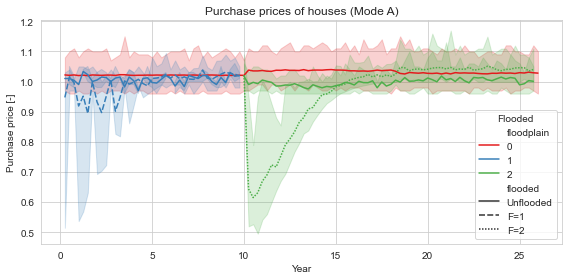

In [12]:
fig3, ax3 = plt.subplots(figsize=(8, 4))
test_trans_plot = test_trans_df.reset_index()
test_trans_plot['step'] = test_trans_plot['step'].astype(int) / 4
sns.lineplot(data=test_trans_plot, x='step', y='win_bid', hue='floodplain', style='flooded', palette='Set1',
             errorbar=('pi', 100))
plt.legend(loc='lower right', title='Flooded')
plt.title('Purchase prices of houses (Mode A)')
plt.xlabel('Year')
plt.ylabel('Purchase price [-]')
plt.tight_layout()
plt.savefig('data_model_outputs/trial_outputs/trial_A_plot_deltas,binary.jpg', dpi=500)

## Graphing House price over time

In [13]:
# need to make the prices into ratios. Base it on
# test_raw_df = raw_df.copy(deep=True)
#
# # slice and get ratio
# test_raw_df['h_value_r'] = 0.
# test_raw_df['flood_event'] = 0
# # get all agents from categories (such a time-saver)
# h_agents = test_raw_df.index.get_level_values('unique_id').categories
#
# # Sort Household agents into categories depending on flood exposure
# try:  # do a conditional check to sort, using np.select
#     conditions = [
#         (exp_df[0] > 0) & (exp_df[1] > 0),
#         (exp_df[0] > 0),
#         (exp_df[1] > 0)]
#     outcomes = ['1+2', '1', '2']
#     exp_df['category'] = np.select(conditions, outcomes, default='none')
#     exp_df['category'] = exp_df['category'].astype('category')  # cast to category for faster sorting
# except KeyError:  # should not happen now
#     exp_df['category'] = 'none'

# counts = exp_df['category'].value_counts()


In [14]:
# iterate through all agents and calculate
# for iter_n, agent in enumerate(h_agents):
#     sliced = test_raw_df.loc[(slice(None), agent), :]  # sort for all agents
#     test_raw_df.loc[sliced.index, 'h_value_r'] = sliced['h_value'] / sliced['h_value'][1] # divide home value over value at t=1
#     # also append category of agent in extra column, used for plot later
#     test_raw_df.loc[sliced.index, 'flood_event'] = exp_df.loc[agent, 'category']



In [15]:
# append which scenario the area got flooded.
# if houses were flooded, append event number to column
# we already know which homes are flooded in this run
# iterate through that
# how to tell? -> based on


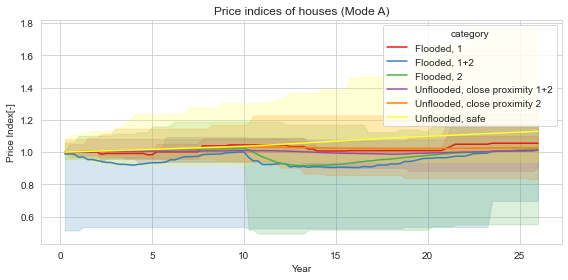

In [18]:
fig4, ax4 = plt.subplots(figsize=(8, 4))
test_raw_plot = raw_df.reset_index()
counts = test_raw_plot.category.value_counts()
test_raw_plot['step'] = test_raw_plot['step'].astype(int) / 4
# test_raw_plot.rename(columns={"fld_exp": "Flooded"}, inplace=True)  # rename column for plotting
# sns.lineplot(data=test_raw_plot, x='step', y='h_value', hue='category', errorbar=('pi',100),palette='Set1')
# # plt.legend(loc='lower right', title='Flooded')
# plt.title('Price indices of houses (Mode A)')
# plt.xlabel('Year')
# plt.ylabel('Price Index[-]')
# plt.tight_layout()
# plt.savefig('data_model_outputs/trial_outputs/trial_A_priceindices.jpg', dpi=500)


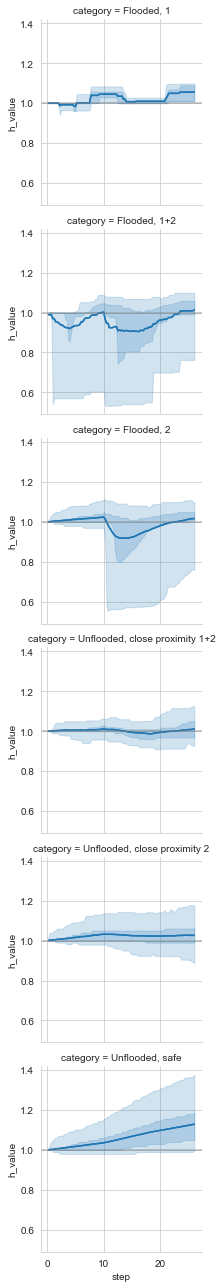

In [34]:
# fig5, ax5 = plt.subplots(figsize=(8,4))
# test_raw_plot = test_raw_df.reset_index()
# test_raw_plot['step'] = test_raw_plot['step'].astype(int) / 4 # floor div
# sns.boxplot(data=test_raw_plot, x='step',y='h_value_r', hue='flood_event', palette='Set1', fliersize=0.2)
# sns.pointplot(data=test_raw_plot, x='step',y='h_value_r', hue='flood_event', palette='Set1', errwidth=0.5, dodge=True)

fg = sns.FacetGrid(test_raw_plot, row='category', legend_out=True)
fg.map(sns.lineplot, 'step', 'h_value', **{'errorbar' : ('pi', 95)})
fg.map(sns.lineplot, 'step', 'h_value', **{'errorbar' : ('pi', 50)})
fg.refline(y=1., color='grey', linestyle='-',**{'alpha':0.5})

# for idx, count in enumerate(counts):
#     fg.axes[idx]

plt.tight_layout()

In [29]:
list(fg.axes.flat)[0].title


Text(0.5, 1.0, 'category = Flooded, 1')